Epoch 1/10
Train Loss: 0.3320 Acc: 0.9028
Val Loss: 0.1535 Acc: 0.9542
Epoch 2/10
Train Loss: 0.1110 Acc: 0.9661
Val Loss: 0.1046 Acc: 0.9705
Epoch 3/10
Train Loss: 0.0721 Acc: 0.9776
Val Loss: 0.1007 Acc: 0.9715
Epoch 4/10
Train Loss: 0.0545 Acc: 0.9833
Val Loss: 0.0805 Acc: 0.9765
Epoch 5/10
Train Loss: 0.0408 Acc: 0.9865
Val Loss: 0.0828 Acc: 0.9780
Epoch 6/10
Train Loss: 0.0320 Acc: 0.9898
Val Loss: 0.0743 Acc: 0.9782
Epoch 7/10
Train Loss: 0.0253 Acc: 0.9916
Val Loss: 0.0934 Acc: 0.9757
Epoch 8/10
Train Loss: 0.0210 Acc: 0.9930
Val Loss: 0.0857 Acc: 0.9783
Epoch 9/10
Train Loss: 0.0169 Acc: 0.9943
Val Loss: 0.0872 Acc: 0.9765
Epoch 10/10
Train Loss: 0.0173 Acc: 0.9941
Val Loss: 0.0954 Acc: 0.9760


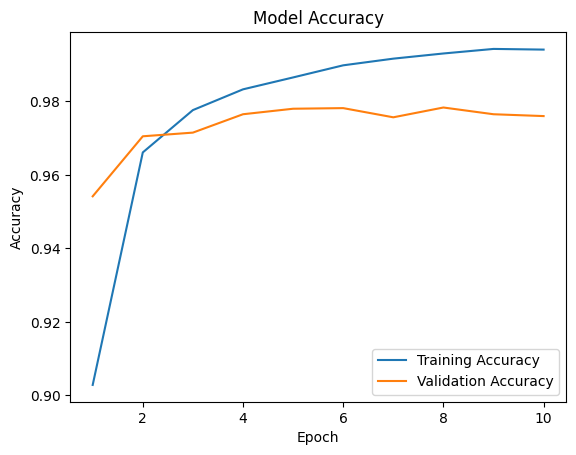

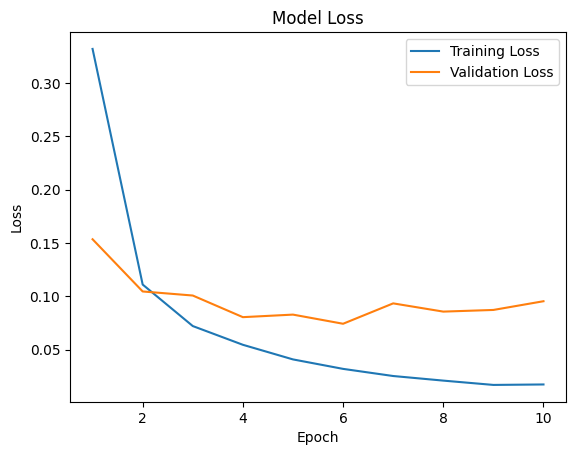

Validation Loss: 0.0954
Validation Accuracy: 0.9760


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# Load the training data
train_data = pd.read_csv('mnist_train.csv')

# Separate features and labels
y_train = train_data.iloc[:, 0].values
X_train = train_data.iloc[:, 1:].values.astype(np.float32) / 255.0

# Convert to torch tensors
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train, dtype=torch.long)

# Create custom dataset
class MNISTDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MNISTDataset(X_train, y_train)

# Split into training and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define the model
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 128)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x

model = MNISTModel()

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    
    # Validation Phase
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            outputs = model(val_inputs)
            loss = criterion(outputs, val_labels)
            _, preds = torch.max(outputs, 1)
            val_running_loss += loss.item() * val_inputs.size(0)
            val_running_corrects += torch.sum(preds == val_labels.data)
    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = val_running_corrects.double() / len(val_dataset)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc.item())
    
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    print(f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')

# Plot accuracy
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on validation set
model.eval()
val_running_loss = 0.0
val_running_corrects = 0
with torch.no_grad():
    for val_inputs, val_labels in val_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        outputs = model(val_inputs)
        loss = criterion(outputs, val_labels)
        _, preds = torch.max(outputs, 1)
        val_running_loss += loss.item() * val_inputs.size(0)
        val_running_corrects += torch.sum(preds == val_labels.data)
val_loss = val_running_loss / len(val_dataset)
val_acc = val_running_corrects.double() / len(val_dataset)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_acc:.4f}')


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# Load the test data
test_data = pd.read_csv('Project_Data_EE4C12_CE_IMG.csv')

# Verify the structure of test_data
print('Test data columns:', test_data.columns)
print(test_data.head())

# Assuming labels are in the first column and features are from the second column onwards
y_test = test_data.iloc[:, 0].values
X_test = test_data.iloc[:, 1:].values.astype(np.float32) / 255.0

# Convert to torch tensors
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test, dtype=torch.long)

# Verify shapes and data types
print('X_test shape:', X_test.shape)  # Should be (num_samples, 784)
print('y_test shape:', y_test.shape)  # Should be (num_samples,)
print('X_test dtype:', X_test.dtype)  # Should be torch.float32
print('y_test dtype:', y_test.dtype)  # Should be torch.int64 (long)

# Check for NaN values
print('Any NaN in X_test:', torch.isnan(X_test).any())
print('Any NaN in y_test:', torch.isnan(y_test).any())

# Check if labels are within the expected range [0, 9]
unique_labels = torch.unique(y_test)
print('Unique labels in y_test:', unique_labels)
if unique_labels.min() < 0 or unique_labels.max() > 9:
    print('Warning: Labels are out of expected range [0, 9]')

# Create test dataset and loader using the same MNISTDataset class
class MNISTDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

test_dataset = MNISTDataset(X_test, y_test)
batch_size = 128  # Ensure this is defined
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate the model
model.eval()

test_running_loss = 0.0
test_running_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        # Check for NaN or Inf in outputs
        if torch.isnan(outputs).any() or torch.isinf(outputs).any():
            print("Invalid values detected in model outputs.")
            continue  # Skip this batch

        loss = criterion(outputs, labels)

        # Check for NaN or Inf in loss
        if torch.isnan(loss).item() or torch.isinf(loss).item():
            print("Invalid loss value detected.")
            continue  # Skip this batch

        _, preds = torch.max(outputs, 1)
        test_running_loss += loss.item() * inputs.size(0)
        test_running_corrects += torch.sum(preds == labels.data)

test_loss = test_running_loss / len(test_dataset)
test_acc = test_running_corrects.double() / len(test_dataset)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

# Save the model
torch.save(model.state_dict(), 'mnist_dnn_model.pth')


Test data columns: Index(['7', '0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8',
       ...
       '0.658', '0.659', '0.660', '0.661', '0.662', '0.663', '0.664', '0.665',
       '0.666', '0.667'],
      dtype='object', length=785)
   7  0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  ...  0.658  0.659  0.660  \
0  2  0    0    0    0    0    0    0    0    0  ...    0.0    0.0    0.0   
1  1  0    0    0    0    0    0    0    0    0  ...    0.0    0.0    0.0   
2  0  0    0    0    0    0    0    0    0    0  ...    0.0    0.0    0.0   
3  4  0    0    0    0    0    0    0    0    0  ...    0.0    0.0    0.0   
4  1  0    0    0    0    0    0    0    0    0  ...    0.0    0.0    0.0   

   0.661  0.662  0.663  0.664  0.665  0.666  0.667  
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
4    0.0    0.0    0.0    0.0 

In [13]:
# Load the test data
test_data = pd.read_csv('Project_Data_EE4C12_CE_IMG.csv')

y_test = test_data.iloc[:, 0].values  
X_test = test_data.iloc[:,1:].values.astype(np.float32) / 255.0
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test, dtype=torch.long)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
# Create test dataset and loader
class MNISTTestDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

test_dataset = MNISTTestDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate the model
model.eval()

test_running_loss = 0.0
test_running_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        test_running_loss += loss.item() * inputs.size(0)
        test_running_corrects += torch.sum(preds == labels.data)

test_loss = test_running_loss / len(test_dataset)
test_acc = test_running_corrects.double() / len(test_dataset)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

# Save the model
torch.save(model.state_dict(), 'mnist_dnn_model.pth')

X_train shape: torch.Size([60000, 784])
X_test shape: torch.Size([8042, 784])
Test Loss: nan
Test Accuracy: 0.9731
